In [37]:
%load_ext autoreload
%autoreload 2
from cppn_torch.activation_functions import *
from matplotlib import pyplot as plt
import imageio.v2 as iio
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from move import MOVE
from move_config import MoveConfig
from cppn_torch.util import center_crop, resize
from cppn_torch import ImageCPPN

from torchviz import make_dot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
target_name = "https://upload.wikimedia.org/wikipedia/commons/1/1e/Sunrise_over_the_sea.jpg"
# target_name = "data/skull.png"
# target_name = "https://media.istockphoto.com/id/689364180/vector/smiling-cartoon-face-positive-people-emotion-icon.jpg?s=612x612&w=0&k=20&c=2olrbVI2dkVyR0XKaMs4cSDrzpA4zH4FrCfZ_rKwVjU="


In [39]:
from run_setup import run_setup, fix_target_dimensions
from evolution_torch.algorithm_config import resize_target
config = MoveConfig()
# config.color_mode = "HSL"
config.color_mode = "L"
config.target =  target_name
config.target_name = 'default'
config.experiment_condition = 'demo'
config.target_res = [100, 100]
pilmode = "RGB" if len(config.color_mode) == 3 else "L"
config.target = torch.tensor(iio.imread(config.target, pilmode=pilmode, as_gray=len(config.color_mode)==1), dtype=torch.float32, device=config.device) / 255.0

import cppn_torch.activation_functions as af
import fitness.fitness_functions as ff
# config.activations = [af.identity, af.sin]
config.hidden_nodes_at_start = (8, 8)
# config.objective_functions = [ff.mse, ff.mse, ff.mse, ff.mse]

config.objective_functions =[
            "psnr",
            "mse",
            # "lpips",
            # "dists",
            "ssim",
            # "style",
            "haarpsi",
            "vif",
            "msssim",
            "dss",
            "gmsd",
            # "fsim", # nan in gradients
            # "mdsi", # nan in gradients
            # "vsi"   # nan in gradients
            # 'n_cells'
            ]

config.fourier_feature_scale = 10.0
config.n_fourier_features = 8
config.batch_size = 2
config.initial_batch_size = 16

config.sgd_steps = 1

config.num_generations = 100000

config.enforce_initial_fill = False

config.low_mem = True



mut_mod = .2

config.prob_mutate_activation = .15 * mut_mod
config.prob_add_connection = .15 * mut_mod 
config.prob_add_node = .15 * mut_mod
config.prob_remove_node = 0.05 * mut_mod 
config.prob_disable_connection = .05 * mut_mod

config.prob_mutate_activation *= mut_mod
config.prob_add_connection *= mut_mod 
config.prob_add_node *= mut_mod 
config.prob_remove_node *= mut_mod 
config.prob_disable_connection *= mut_mod


config.population_size = 165
config.num_cells = 165

config.output_dir = "../results/demo"


resize_target(config)
fix_target_dimensions(config)


In [40]:
move = MOVE(config)


WARN: less combinations than cells, filling with random repeats
Using 165 out of 56 possible combinations
Number of cells:  165
Initialized MOVE on device: cuda:0


In [41]:
import os
import shutil
print(config.output_dir)
if os.path.exists(config.output_dir):
    shutil.rmtree(config.output_dir)

../results/demo


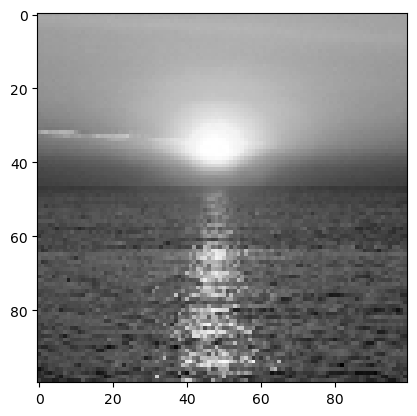

In [42]:

plt.imshow(move.config.target.cpu().numpy(), cmap='gray')
plt.show()

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict

class NodeModule(nn.Module):
    def __init__(self, node, incoming_connections):
        super(NodeModule, self).__init__()
        self.node = node
        self.incoming = nn.Parameter(torch.tensor([c.weight for c in incoming_connections], dtype=torch.float32))
        self.activation = node.activation

    def forward(self, *inputs):
        if len(self.incoming) == 0:
            return self.activation(torch.stack(inputs))
        weighted_sum = sum(w * inp for w, inp in zip(self.incoming, inputs))
        return self.activation(weighted_sum)

class CPPNModule(nn.Module):
    def __init__(self, layers, connections):
        super(CPPNModule, self).__init__()
        self.layers = layers
        self.connections = connections
        # Organize connections by target node
        conns_by_target = defaultdict(list)
        for conn in connections.values():
            conns_by_target[conn.to_node].append(conn)

        # Create a module for each node
        self.node_modules = nn.Moda
# s = time.time()
# img = net(move.inputs)
# print(time.time() - s)
# img = net(move.inputs).cpu().detach().numpy()
# plt.imshow(img, cmap="gray"); plt.show()

# img2 = cppn_out.cpu().detach().numpy()
# plt.imshow(img, cmap="gray"); plt.show()

/home/jackson/projects/cppns/cppn_torch/cppn_torch/util.py:251: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


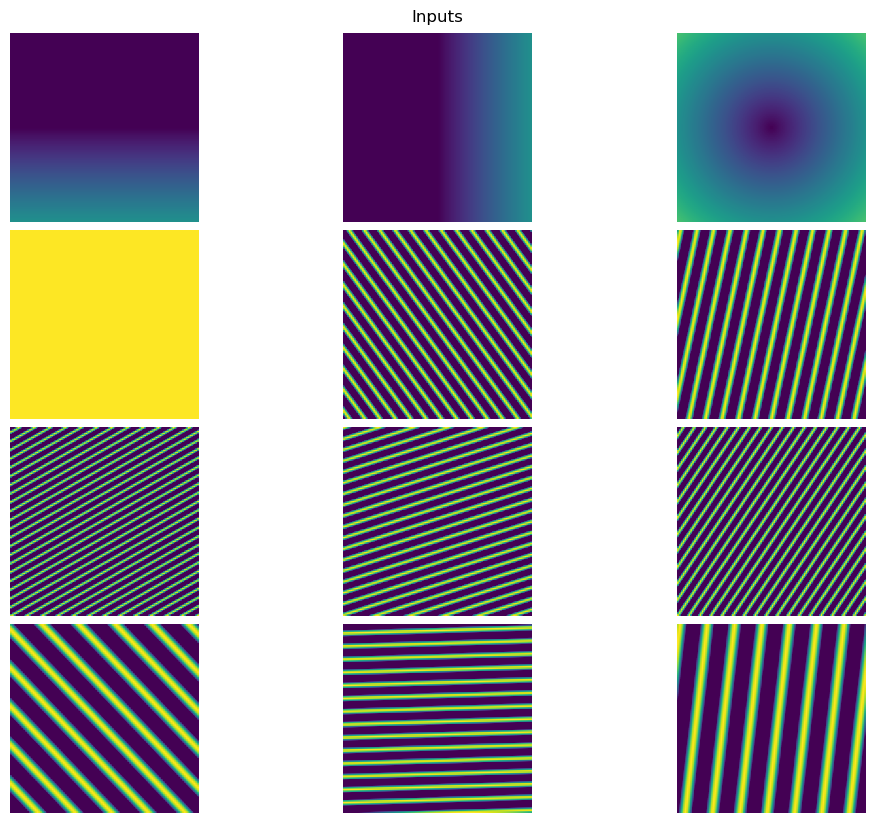

In [44]:
from cppn_torch.util import show_inputs
show_inputs(move.inputs, cols=move.inputs.shape[2]//4)

In [45]:
try:
    move.evolve()
except KeyboardInterrupt:
    pass


Run 1:   0%|          | 0/100000 [00:00<?, ?it/s]



Evolution completed with 473 generations in 286.12670063972473 seconds
Wrapping up, please wait...
Saving data...
Saved run to:  ../results/demo/conditions/demo/run_0000


In [ ]:
# from baseline import norm_tensor
# normed_fits = torch.ones(move.record.fitness_over_time.shape) * -torch.inf
# for fn_i in range(move.record.fitness_over_time.shape[0]):
#     fn_name = move.fns[fn_i].__name__
#     normed_fits[fn_i] = norm_tensor(move.record.fitness_over_time[fn_i], move.config.norm_df_path, fn_name)

# plt.plot(normed_fits.mean(dim=(0)).cpu())
# plt.show()

AttributeError: 'Record' object has no attribute 'fitness_over_time'

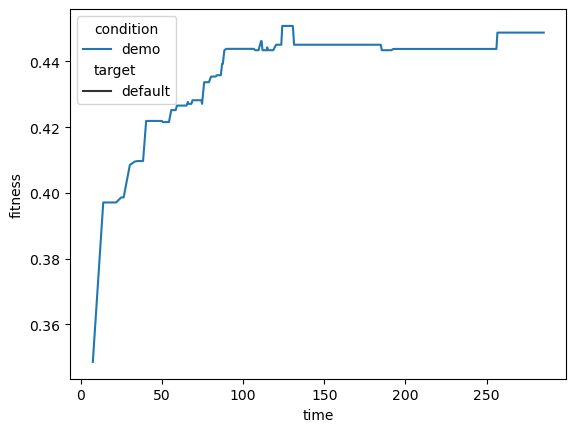

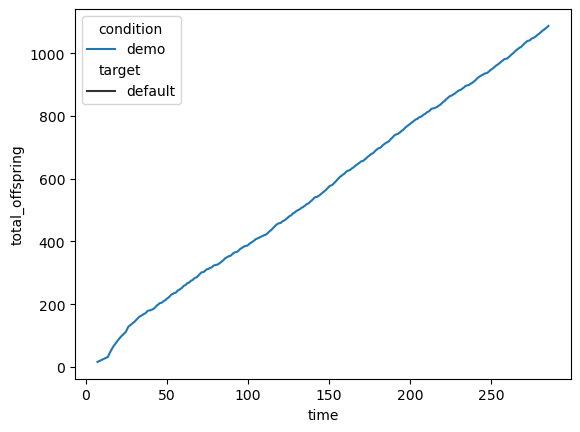

In [46]:
from plot import *
def read_results(results_path):
    fits_path = os.path.join(results_path, "results.pkl")
    df = pd.read_pickle(fits_path)
    return df
results = read_results(move.config.output_dir)
save_path = os.path.join(move.config.output_dir, "plots")
os.makedirs(save_path, exist_ok=True)
# results = results[results["run_id"] >= 0]
# results = results[results["condition"] == "_default"]
plot_vs_time(results, "fitness", save_path, True)
plot_vs_time(results, "total_offspring", save_path, True)


In [ ]:
from util import show_move_map_images
show_move_map_images(move)

In [ ]:
move.solution.draw_nx()

In [ ]:

from cppn_torch.util import visualize_node_outputs
visualize_node_outputs(move.solution, move.inputs);

plt.show()

In [ ]:
print(f"{'Individual in cell' :20s}  {'Lineage'}")
print('-' * 40)
for cell_id, lineage in enumerate(move.get_lineages()):
    print(f"{move.map.cell_names[cell_id]:20s}: {lineage}")
    
print('-' * 40)
print("\n\n* -1: randomly initialized genome")